<a href="https://colab.research.google.com/github/AbhiRajBajpai/TCS-Stock-Data/blob/main/TCS_Stock_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Set plot style for better visuals
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [14]:
try:
    # Load historical stock prices
    history_df = pd.read_csv('TCS_stock_history.csv')

    # Load dividend and stock split data
    action_df = pd.read_csv('TCS_stock_action.csv')

    # Load general company information (formatted as key-value pairs)
    info_df = pd.read_csv('TCS_stock_info.csv', header=None, index_col=0, names=['Value'])

    print("--- 1. TCS Stock History (history_df) ---")
    display(history_df.head())

    print("\n--- 2. TCS Stock Actions (action_df) ---")
    display(action_df.head())

    print("\n--- 3. TCS Company Info (info_df) ---")
    display(info_df)

except FileNotFoundError as e:
    print(f"⚠️ Error: {e}. Please make sure all three CSV files are uploaded.")

--- 1. TCS Stock History (history_df) ---


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2002-08-12,28.794172,29.742206,28.794172,29.519140,212976,0.0,0.0
1,2002-08-13,29.556316,30.030333,28.905705,29.119476,153576,0.0,0.0
2,2002-08-14,29.184536,29.184536,26.563503,27.111877,822776,0.0,0.0
3,2002-08-15,27.111877,27.111877,27.111877,27.111877,0,0.0,0.0
4,2002-08-16,26.972458,28.255089,26.582090,27.046812,811856,0.0,0.0



--- 2. TCS Stock Actions (action_df) ---


,Date,Dividends,Stock Splits
0,2004-10-28,0.3750,0.0
1,2005-02-03,0.4375,0.0
2,2005-07-06,0.6250,0.0
3,2005-08-18,0.3750,0.0
4,2005-10-18,0.3750,0.0



--- 3. TCS Company Info (info_df) ---


,Value
zip,400001
sector,Technology
fullTimeEmployees,509058
longBusinessSummary,Tata Consultancy Services Limited provides inf...
city,Mumbai
...,...
dividendYield,0.0105
bidSize,0
dayHigh,3805
regularMarketPrice,3773.2


In [15]:
# Convert 'Date' columns to datetime objects for both history and action dataframes
history_df['Date'] = pd.to_datetime(history_df['Date'])
action_df['Date'] = pd.to_datetime(action_df['Date'])

# Set the 'Date' column as the index for the history dataframe
history_df.set_index('Date', inplace=True)

print("✅ 'Date' columns converted to datetime objects.")
history_df.info()

✅ 'Date' columns converted to datetime objects.
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4463 entries, 2002-08-12 to 2021-09-30
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          4463 non-null   float64
 1   High          4463 non-null   float64
 2   Low           4463 non-null   float64
 3   Close         4463 non-null   float64
 4   Volume        4463 non-null   int64  
 5   Dividends     4463 non-null   float64
 6   Stock Splits  4463 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 278.9 KB


TCS has paid dividends on 70 occasions in this dataset.


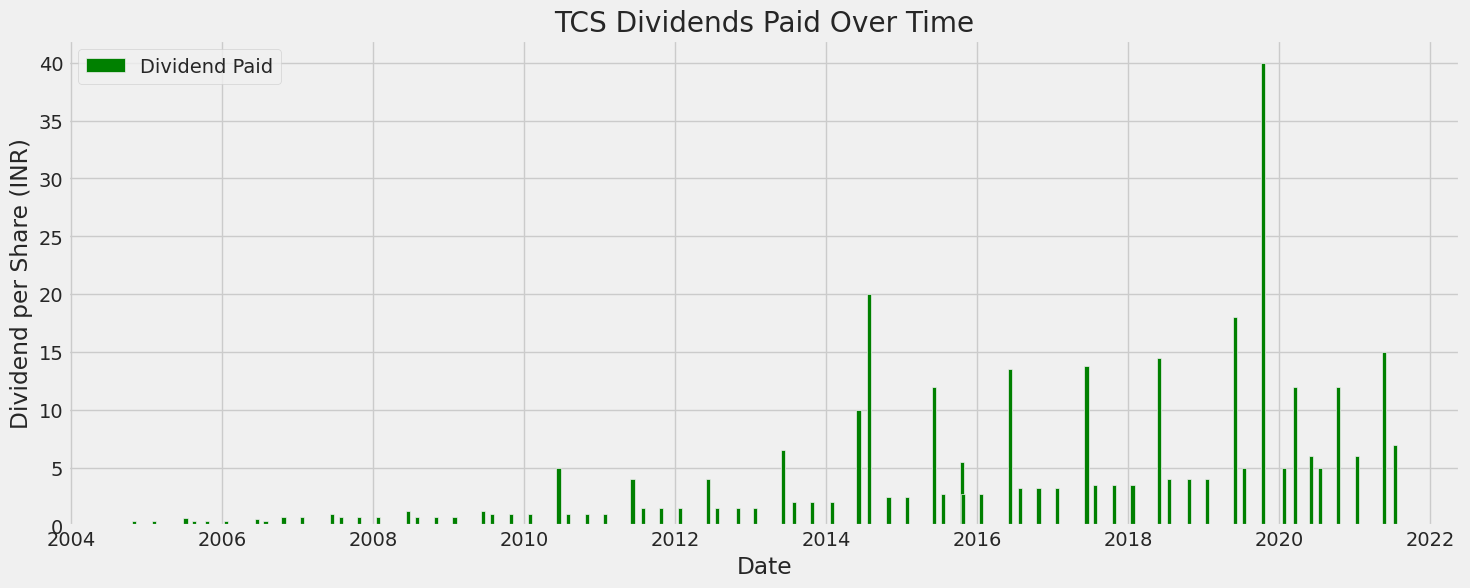


--- Stock Splits Found ---


,Date,Dividends,Stock Splits
7,2006-07-28,0.375,2.0
18,2009-06-16,1.250,2.0
55,2018-05-31,14.500,2.0


In [16]:
# Filter for days when dividends were paid
dividends = action_df[action_df['Dividends'] > 0].copy()
print(f"TCS has paid dividends on {len(dividends)} occasions in this dataset.")

# Plotting dividends over time
plt.figure(figsize=(16, 6))
plt.bar(dividends['Date'], dividends['Dividends'], color='green', width=20, label='Dividend Paid')
plt.title('TCS Dividends Paid Over Time')
plt.xlabel('Date')
plt.ylabel('Dividend per Share (INR)')
plt.legend()
plt.show()

# Check for stock splits
stock_splits = action_df[action_df['Stock Splits'] > 0]
if not stock_splits.empty:
    print("\n--- Stock Splits Found ---")
    display(stock_splits)
else:
    print("\nNo stock splits found in this dataset.")

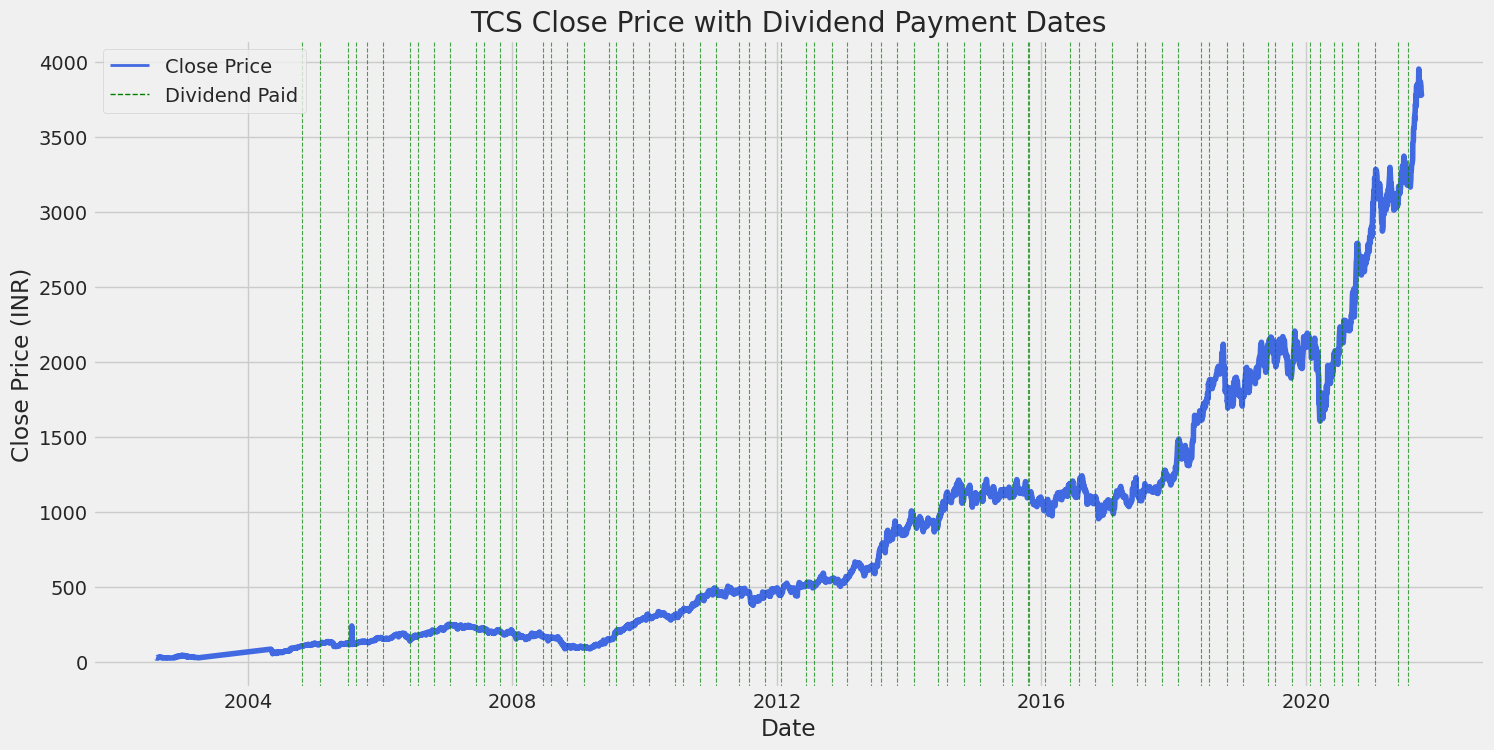

In [17]:
# Plot the closing price from history_df
plt.figure(figsize=(16, 8))
plt.plot(history_df.index, history_df['Close'], label='TCS Close Price', color='royalblue')

# Add vertical lines for each dividend payment date
for date in dividends['Date']:
    plt.axvline(x=date, color='green', linestyle='--', linewidth=0.8, alpha=0.7)

plt.title('TCS Close Price with Dividend Payment Dates')
plt.xlabel('Date')
plt.ylabel('Close Price (INR)')
# Create a custom legend entry for the dividend lines
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='royalblue', lw=2),
                Line2D([0], [0], color='green', linestyle='--', lw=1)]
plt.legend(custom_lines, ['Close Price', 'Dividend Paid'])
plt.show()

In [18]:
# Create a new dataframe with only the 'Close' column
data = history_df.filter(['Close'])
dataset = data.values

# Scale the data to be values between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# Create the training data set
training_data_len = int(np.ceil(len(dataset) * .8))
train_data = scaled_data[0:int(training_data_len), :]

# Split the data into x_train and y_train data sets
x_train = []
y_train = []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

# Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data for the LSTM model [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

print("✅ Data prepared for LSTM model.")
print(f"Shape of training data: {x_train.shape}")

✅ Data prepared for LSTM model.
Shape of training data: (3511, 60, 1)


In [19]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
print("--- Training LSTM Model ---")
model.fit(x_train, y_train, batch_size=1, epochs=1) # Using 1 epoch for quick training
print("\n✅ Model training complete.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


--- Training LSTM Model ---
3511/3511 ━━━━━━━━━━━━━━━━━━━━ 212s 59ms/step - loss: 4.7621e-04

✅ Model training complete.


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step


/tmp/ipython-input-855084143.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


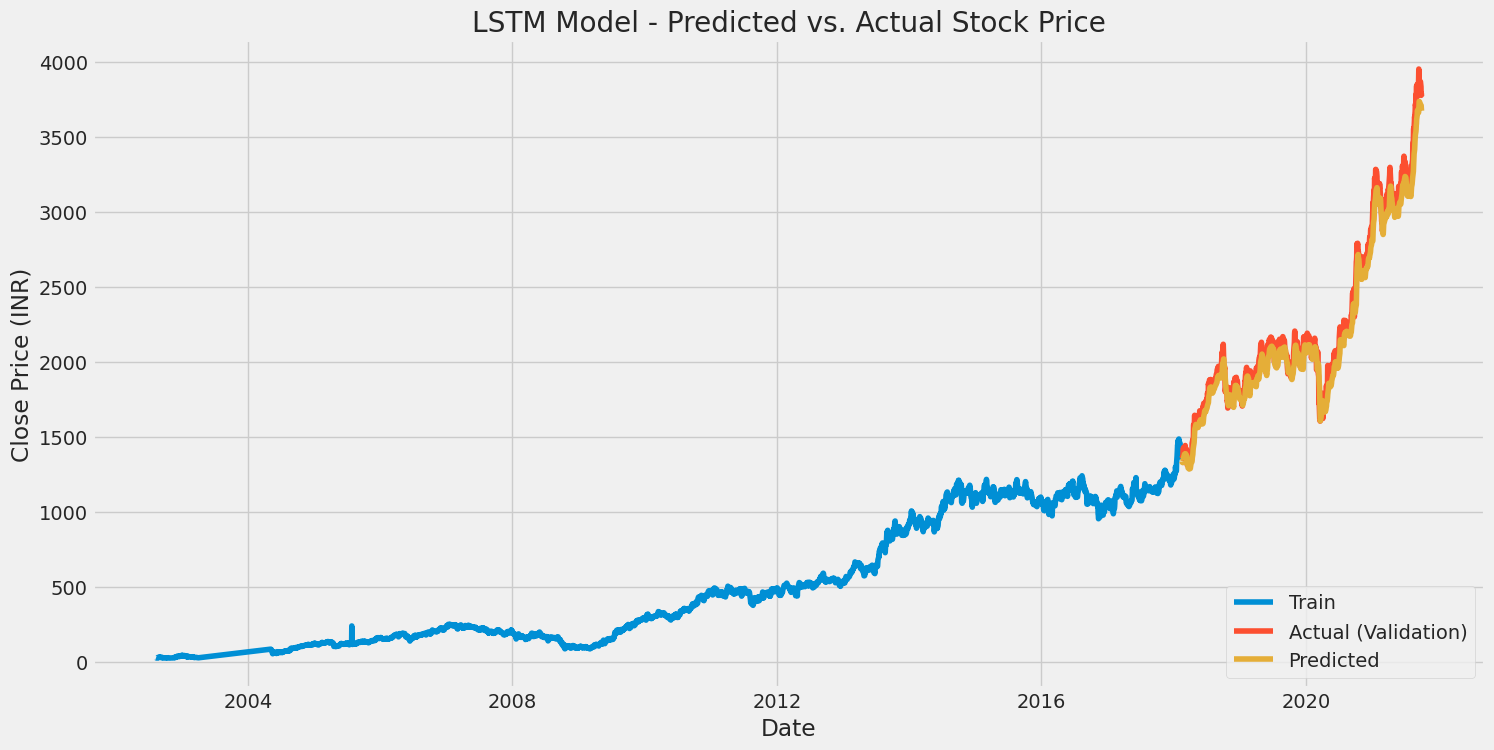

In [20]:
# Create the testing data set
test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert data to a numpy array and reshape
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the model's predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('LSTM Model - Predicted vs. Actual Stock Price')
plt.xlabel('Date')
plt.ylabel('Close Price (INR)')
plt.plot(train['Close'], label='Train')
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Actual (Validation)', 'Predicted'], loc='lower right')
plt.show()